In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop

train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

print("train/validation: ",train_dir)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

print("test: ",test_dir)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

train/validation:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\VGG16\train
Found 232 files belonging to 2 classes.
Using 186 files for training.
Found 232 files belonging to 2 classes.
Using 46 files for validation.
test:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\VGG16\test
Found 59 files belonging to 2 classes.


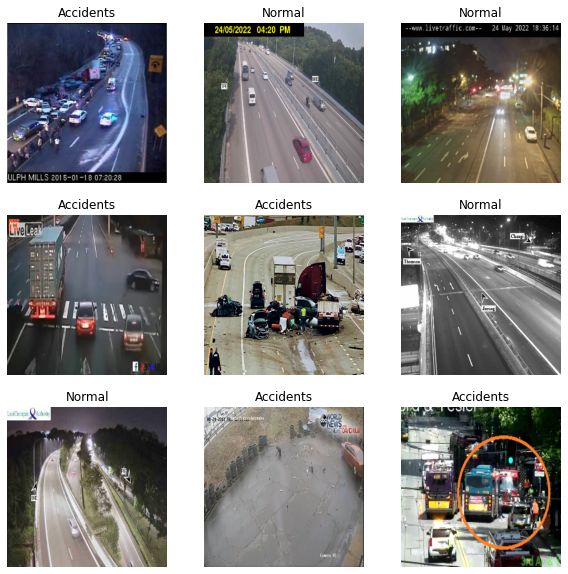

In [2]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset For Performance

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

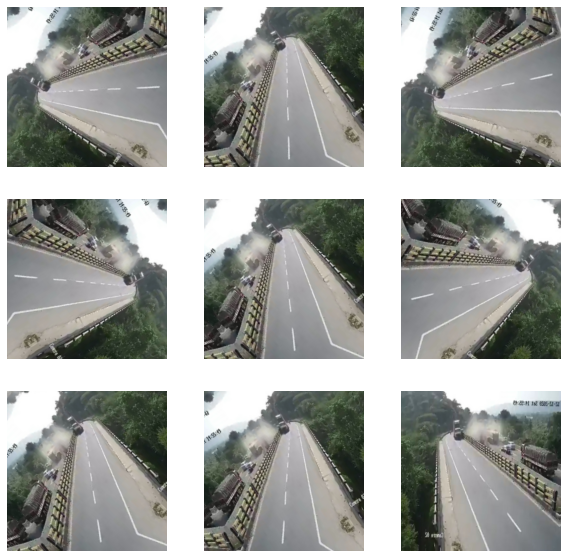

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling Pixel Values

In [5]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Creating Base Model from VGG16

In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = VGG16(weights="imagenet", 
                   include_top=False, 
                   input_shape=IMG_SHAPE)

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(299, 299, 3)
(32, 9, 9, 512)


# Feature Extraction

In [8]:
### Freeze The Convolutional Base
#It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from 
#being updated during training. MobileNet V2 has many layers, so setting the entire model's 
#trainable flag to False will freeze all of them.

base_model.trainable = False

In [9]:
### Important note about BatchNormalization layers

#Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions 
#should be taken in the context of fine-tuning, as shown later in this tutorial. 

#When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will 
#not update its mean and variance statistics. 

#When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep 
#the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. 
#Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

#For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [10]:
### Add a classification head

#To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [12]:
prediction_layer = tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
### Compile the model

#Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` 
#loss with `from_logits=True` since the model provides a linear output.

from keras.optimizers import Adam

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

#The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. 
#These are divided between two `tf.Variable` objects, the weights and biases.

len(model.trainable_variables)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1   (None, 299, 299, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0   

2

In [15]:
### Train the model

#After training for 10 epochs, you should see ~94% accuracy on the validation set.


from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


initial_epochs = 50


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks =[earlystopping])


Epoch 1/50
6/6 [==============================] - 54s 9s/step - loss: 3.4308 - accuracy: 0.3495 - val_loss: 3.0791 - val_accuracy: 0.2609
Epoch 2/50
6/6 [==============================] - 72s 13s/step - loss: 3.3817 - accuracy: 0.3817 - val_loss: 2.8250 - val_accuracy: 0.2826
Epoch 3/50
6/6 [==============================] - 69s 12s/step - loss: 3.1993 - accuracy: 0.3441 - val_loss: 2.5868 - val_accuracy: 0.3043
Epoch 4/50
6/6 [==============================] - 74s 13s/step - loss: 2.8208 - accuracy: 0.3548 - val_loss: 2.3834 - val_accuracy: 0.3261
Epoch 5/50
6/6 [==============================] - 74s 13s/step - loss: 2.6142 - accuracy: 0.3710 - val_loss: 2.2077 - val_accuracy: 0.3043
Epoch 6/50
6/6 [==============================] - 70s 12s/step - loss: 2.3477 - accuracy: 0.3495 - val_loss: 2.0570 - val_accuracy: 0.3043
Epoch 7/50
6/6 [==============================] - 71s 12s/step - loss: 2.1632 - accuracy: 0.3763 - val_loss: 1.9393 - val_accuracy: 0.3043
Epoch 8/50
6/6 [============

# Fine tuning

In [16]:
#In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. 
#The weights of the pre-trained network were **not** updated during training.

#One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the 
#pre-trained model alongside the training of the classifier you added. The training process will force the weights 
#to be tuned from generic feature maps to features associated specifically with the dataset.

#Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set 
#to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train 
#all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) 
#and your pre-trained model will forget what it has learned.

#Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional 
#networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features 
#that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset 
#on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, 
#rather than overwrite the generic learning.

### Un-freeze the top layers of the model


#All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the 
#model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  19


In [18]:

# Fine-tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [19]:
### Compile the model

#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower 
#learning rate at this stage. Otherwise, your model could overfit very quickly.



model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1   (None, 299, 299, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0   

12

In [20]:
### Continue training the model

#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks =[earlystopping])



Epoch 50/100
6/6 [==============================] - 121s 22s/step - loss: 0.8725 - accuracy: 0.7043 - val_loss: 0.4988 - val_accuracy: 0.7174
Epoch 51/100
6/6 [==============================] - 122s 21s/step - loss: 0.5387 - accuracy: 0.7581 - val_loss: 0.3689 - val_accuracy: 0.7609
Epoch 52/100
6/6 [==============================] - 120s 20s/step - loss: 0.3264 - accuracy: 0.8548 - val_loss: 0.2975 - val_accuracy: 0.8043
Epoch 53/100
6/6 [==============================] - 122s 21s/step - loss: 0.3469 - accuracy: 0.8763 - val_loss: 0.2893 - val_accuracy: 0.7826
Epoch 54/100
6/6 [==============================] - 120s 20s/step - loss: 0.2880 - accuracy: 0.8925 - val_loss: 0.2257 - val_accuracy: 0.9130
Epoch 55/100
6/6 [==============================] - 135s 23s/step - loss: 0.1819 - accuracy: 0.9409 - val_loss: 0.2238 - val_accuracy: 0.8913
Epoch 56/100
6/6 [==============================] - 140s 24s/step - loss: 0.1690 - accuracy: 0.9355 - val_loss: 0.2680 - val_accuracy: 0.7826
Epoch 

In [21]:
#Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few 
#layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the 
#training loss, so you may get some overfitting.

#You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


#After fine tuning the model nearly reaches 98% accuracy on the validation set.

acc = history.history['accuracy']
acc += history_fine.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']

val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']



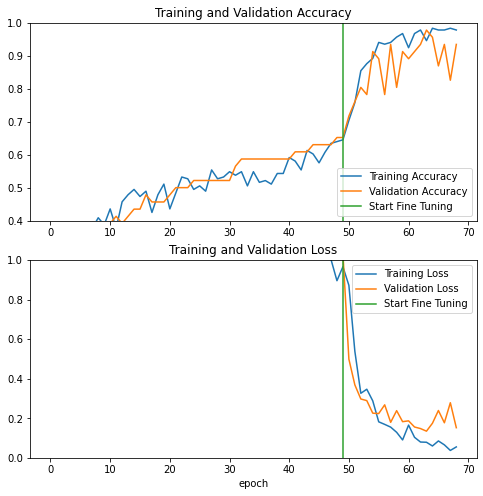

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
### Evaluation and prediction

#Finally you can verify the performance of the model on new data using test set.
loss1, accuracy1 = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy1)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


2/2 [==============================] - 12s 5s/step - loss: 0.1347 - accuracy: 0.9783
Validation accuracy : 0.97826087474823
2/2 [==============================] - 24s 10s/step - loss: 0.8444 - accuracy: 0.7458
Test accuracy : 0.7457627058029175


Predictions:
 [0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1]
Labels:
 [0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0]


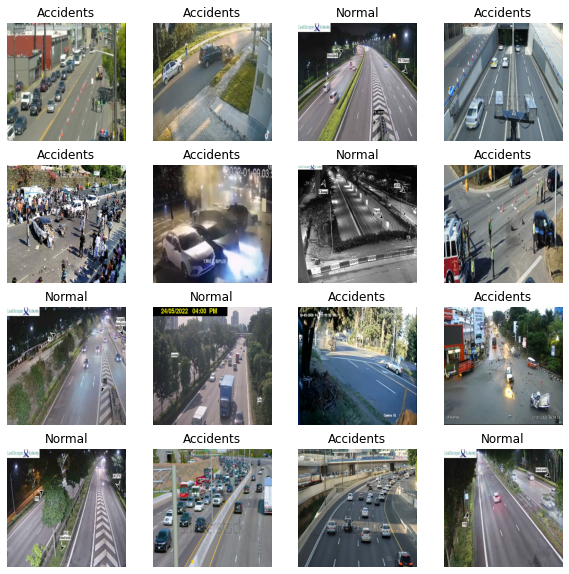

In [25]:
#And now you are all set to use this model to predict if your pet is a normal or accident.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")